# Reconstruction problem notebook

## Библиотеки, параметры, константы задачи

In [1]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
from common.fstream import read_tensor, read_matrix, rescale_array

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="model_19", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cuda:0")


## Загрузка данных

### Восстанавление $\left|k\right|$ по $\left|y_{выч}\right|$, разделённому на левую ($\left|y_{выч}\right|_{L}$) и правую ($\left|y_{выч}\right|_{R}$) части

In [49]:
env.clear_features_and_targets()
env \
    .set_batch_size(train_batch_size=4, val_batch_size=4) \
    \
    .load_feature(
        width=40, height=80, feature_name="Uvych_abs_left.xls", mapper=read_matrix
    ) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_abs_right.xls", mapper=read_matrix
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_tensor
    ) \
    

print(env.train_count, env.val_count)


231
16


### Восстанавление $\left|k\right|$ из $\tilde{\left|k\right|}$ (noised)

In [2]:
env.clear_features_and_targets()

env \
    .set_batch_size(train_batch_size=32, val_batch_size=4) \
    \
    .load_feature(
        width=80, height=80, feature_name="K_noised_abs.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=80, height=80, target_name="K_abs.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

28 16


### Восстанавление $\left|y_{выч}\right|_{L}$ из $\tilde{\left|y_{выч}\right|_{L}}$ (noised)


In [2]:
env.clear_features_and_targets()

env \
    .set_batch_size(train_batch_size=4, val_batch_size=4) \
    .load_feature(
        width=40, height=80, feature_name="Uvych_noised_abs_left.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        width=40, height=80, target_name="Uvych_abs_left.xls", mapper=read_matrix, transform=None
    ) \
    
print(env.train_count, env.val_count)

231 16


===================================================================================================================================

## Модели

### VQGAN

In [26]:
env.model = models.vqgan.VQGAN_mod(type('', (object, ), 
                                        {'image_channels': 1, 
                                         'latent_dim': 256, 
                                         'device': env.device_name, 
                                         'num_codebook_vectors': 1024, 
                                         'beta': 0.25})()) \
             .to(env.device)

### U-net

In [12]:
env.model = models.UnetAutoencoder.UNetAuto(num_channels=1, num_out_channels=1, max_features=1024).to(env.device)

### Новая локальная модель

In [54]:
env.init_model(models.autoencoders.ConvAutoencoderLumaRelu)

New model created.


### Импорт претренерованной модели

In [3]:
env.load_model(model_type="pt")

===================================================================================================================================

## Визуализация батча валидационного датасета

/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


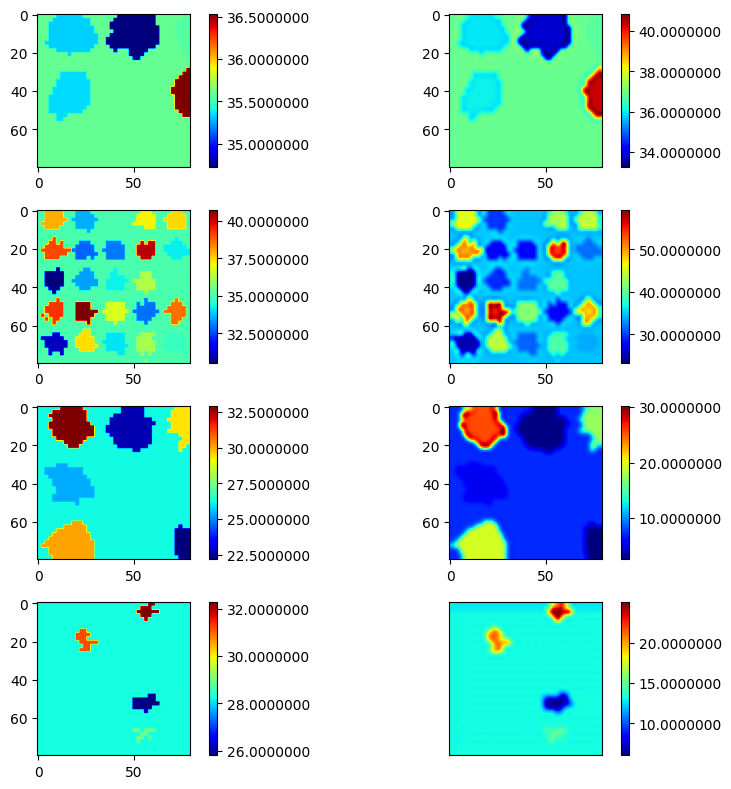

In [4]:
env.plot_batch(0)

===================================================================================================================================

## Численные значения отклонений

In [5]:
def test():
    losses = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features)
            loss = torch.max(torch.abs(outputs - data_target))
            losses.append(loss.detach().tolist())
            
    print("Среднее отклонение по значениям в векторе:", sum(losses) / len(losses))
    print("Максимальное отклонение по значениям в векторе:", max(losses))
    
test()

Среднее отклонение по значениям в векторе: 12.181765019893646
Максимальное отклонение по значениям в векторе: 22.806041717529297


===================================================================================================================================

## Training

In [6]:
from common.losses import MseCoeffLoss

# optimizer = torch.optim.Adam(env.model.parameters(), lr=0.00001)
# #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.65 ** epoch)
# 
# env.train(3, step_saving=False, step_plotting=False,
#           optimizer=optimizer, scheduler=None, 
#           criterion=MyLoss(reduce="none", reduction="none", coeff=10000000.0))


optimizer = torch.optim.Adam(env.model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.65 ** epoch)

env.train(2, step_saving=True, step_plotting=False,
          optimizer=optimizer, scheduler=None, 
          criterion=MseCoeffLoss(reduce="none", reduction="none", coeff=1.0))

/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 8.740772 	Validating Loss: 47.332344 	Time: 0.56 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 9.982643 	Validating Loss: 46.206490 	Time: 0.55 m



## Сохранение модели

In [80]:
env.save(onnx=False, pth=False)

## Loss visualisation

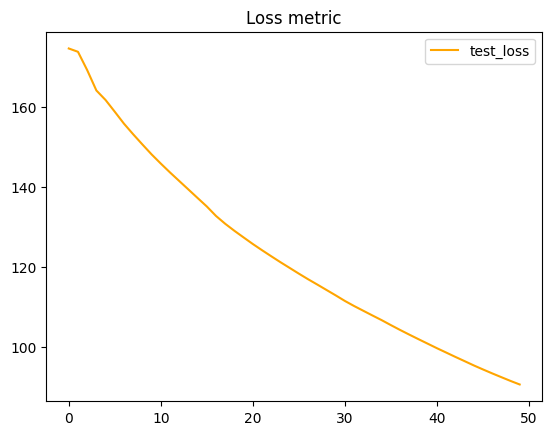

In [71]:
import matplotlib.pyplot as plt
plt.close()
plt.cla()
plt.clf()
plt.plot(env.test_losses[-50:], label="test_loss", color="orange")
plt.legend()
plt.title("Loss metric")
plt.show()


In [ ]:
env.show_metrics(n_last=10)

## Clear memory

In [9]:
import gc
gc.collect()


88951

In [6]:
env.model.cpu()
del env.model

torch.cuda.empty_cache()

In [10]:
torch.cuda.empty_cache()